In [1]:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D

from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from keras import initializers 

import cv2 
import pickle
import numpy as np

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import glob
import csv
import seaborn as sn
import pandas as pd

 

Using TensorFlow backend.


In [2]:
print(dir(ImageDataGenerator))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'fit', 'flow', 'flow_from_directory', 'random_transform', 'standardize']


In [47]:

def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(5,5)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])
            

In [3]:
# the original training set from 
training_file_original = "/home/workspace/CarND-Traffic-Sign-Classifier-Project/train.p"

with open(training_file_original, mode='rb') as f:
    train = pickle.load(f)
X_train_original, y_train_original = train['features'], train['labels']

print ("len(y_train_original)=",len(y_train_original))
print("X_train_original.shape ",X_train_original.shape)
print("y_train_original.shape ",y_train_original)
# the augmented training set created out of the original training set 
training_file_additional = '//home/workspace/CarND-Traffic-Sign-Classifier-Project/train_augmented_p1.p'

with open(training_file_additional, mode='rb') as g:
    augmented = pickle.load(g)
#print("type(augmented)",type(augmented))
X_train_additional, y_train_additional = augmented['features'], augmented['labels']

# Colating both sets together 
X_train_augmented=np.concatenate((X_train_additional, X_train_original), axis=0)
y_train_augmented=np.concatenate((y_train_additional, y_train_original), axis=0)

# sanity check 
print ("len(y_train_augmented)=",len(y_train_augmented))
print("X_train_augmented.shape ",X_train_augmented.shape)
print("y_train_augmented.shape ",y_train_augmented.shape)

# picking the augmented set to train on:
X_train, y_train = X_train_augmented, y_train_augmented 


len(y_train_original)= 34799
X_train_original.shape  (34799, 32, 32, 3)
y_train_original.shape  [41 41 41 ..., 25 25 25]
len(y_train_augmented)= 86516
X_train_augmented.shape  (86516, 32, 32, 3)
y_train_augmented.shape  (86516,)


In [ ]:
X_s, y_s = shuffle(X_train_original, y_train_original, random_state=0)
grid_display(X_s[:4], y_s[:4], no_of_columns=2, figsize=(1.5,1.5))

In [4]:
# loading validation and testing sets
validation_file='/home/workspace/CarND-Traffic-Sign-Classifier-Project/valid.p'
testing_file = '/home/workspace/CarND-Traffic-Sign-Classifier-Project/test.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
X_validation, y_validation = valid['features'], valid['labels']
print("len(X_validation)",len(X_validation))    
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']
print("len(X_test)",len(X_test))    

# normalization 
X_train=(X_train-127.5)/127.5
X_validation=(X_validation-127.5)/127.5
X_test=(X_test-127.5)/127.5

# z-score
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
# sanity check
print('mean',mean)
print("std",std)
# standardization
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)
X_validation=(X_validation-mean)/(std+1e-7)

# checking classes labels-mean
print("min(y_train",min(y_train))
print("max(y_train)",max(y_train))


# pickling for future testing set or other testing samples normalization 
std_mean="/home/workspace/CarND-Traffic-Sign-Classifier-Project/std_mean.p"
with open(std_mean, mode='wb') as h:
    pickle.dump((std,mean),h)


len(X_validation) 4410
len(X_test) 12630
mean -0.508189404645
std 0.440528059621
min(y_train 0
max(y_train) 42


In [ ]:
from keras import activations
from keras.layers import LeakyReLU

rate=0.12
model=Sequential([
    Conv2D(filters=24, kernel_size=(5,5),padding='same', strides= 1,activation='relu',kernel_initializer="he_normal",input_shape=(32,32,3)),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=None),
    #Dropout(rate),
    Conv2D(filters=32, kernel_size=(5,5),padding='same',strides=1,kernel_initializer="he_normal", activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=None ),
    #Dropout(rate),
    Flatten(),
    Dense(units=242, activation='relu',kernel_initializer="he_normal"),
    #BatchNormalization(),
    Dropout(rate),
    Dense(units=121, activation='relu',kernel_initializer="he_normal"),
    #BatchNormalization(),
    Dropout(rate),
    Dense(units=84, activation='relu',kernel_initializer="he_normal"),
    #BatchNormalization(),
    Dropout(rate),
    Dense(units=43, activation = 'softmax')
])

In [ ]:
242, 121, 84 


In [ ]:
model.summary()

In [ ]:
# on the fly data augmentation

from keras.utils import to_categorical

# standardizing channel shift variable
channel_shift_range=150
channel_shift_range=(channel_shift_range-127.5)/127.5
channel_shift_range = (channel_shift_range-mean)/(std+1e-7)

# batches
training_batch_size=100
validation_batch_size=100
test_batch_size=30

# ranges for randomimages transformation 
float_range=0.2
degree_range=10

# reshape the input to the batch sizes ( channel last) 
X_train = X_train.reshape((-1, 32, 32, 3))
X_validation=X_validation.reshape((-1, 32, 32, 3))


# generator below uses ".flow since images are not stored on disk but unpickled 
# set up the tranforms for the training pipeline
train_batches=ImageDataGenerator(rotation_range=degree_range,
                                 width_shift_range=float_range,
                                 height_shift_range=float_range,
                                 shear_range=float_range,
                                 channel_shift_range=channel_shift_range,
                                 zoom_range=float_range
                                ).flow(X_train, to_categorical(y_train,43), batch_size=training_batch_size)

#no tranform during validation 
validation_batches=ImageDataGenerator().flow(X_validation, to_categorical(y_validation,43), batch_size=validation_batch_size)
#test_batches=ImageDataGenerator().flow(X_test, y_test, batch_size=test_batch_size)
#(lr=0.001,decay=1e-6)

In [ ]:
model.compile(Adam(lr=1e-3,decay=1e-6),loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
number_of_epochs= 40
training_steps_per_epoch=int(len(X_train)/training_batch_size)
validation_steps=int(len(X_validation)/validation_batch_size)
test_steps=int(len(X_test)/test_batch_size)

model.fit_generator(train_batches,steps_per_epoch=training_steps_per_epoch,epochs=number_of_epochs,validation_data= validation_batches,validation_steps=validation_steps,verbose=2)


In [ ]:
# test 
test_batch_size=30
test_batches=ImageDataGenerator().flow(X_test, to_categorical(y_test,43), batch_size=test_batch_size)
predictions=model.predict_generator(test_batches,steps=len(X_test)//test_batch_size,verbose=2)

In [ ]:
predictions

In [ ]:
model.save("model_augmented.h5" )

In [5]:
from keras.models import load_model
model=load_model("model_augmented.h5")

In [6]:

from keras.models import load_model
model=load_model("model_augmented.h5")
model.summary()
from keras.utils import to_categorical


import pickle 
std_mean="/home/workspace/CarND-Traffic-Sign-Classifier-Project/std_mean.p"
with open(std_mean, mode='rb') as h:
    (std,mean) = pickle.load(h)

print("(std,mean) =",(std,mean))

testing_file = '/home/workspace/CarND-Traffic-Sign-Classifier-Project/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']
X_test=(X_test-127.5)/127.5
X_test = (X_test-mean)/(std+1e-7)
X_test = X_test.reshape((-1, 32, 32, 3))

print("len(X_test)",len(X_test))


results = model.evaluate(X_test, to_categorical(y_test,43), batch_size=30, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 24)        96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        19232     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [7]:
print("Test Set Loss =", results[0]," Test Set Accuracy =", int(round(results[1]*100)),"%")

Test Set Loss = 0.169496763192  Test Set Accuracy = 95 %


In [8]:
import random
import numpy as np
#picking 3 images randomly from the web site "the Institüt fur NeuroInformatik" 
p=random.sample(range(len(X_test)-1), k=3)
predictions = model.predict(X_test[p])
N=5
indices = np.argpartition(predictions, -N, axis=1)[:, -N:]

print ( "top 5  predictions on for 3 images: \n",indices)

# comparing top predictions to labels: 
N=1
indices = np.argpartition(predictions, -N, axis=1)[:, -N:]
print("Highest score prediction on these 3 images : ", indices.tolist(), "/ Real labels :  ",y_test[p])


top 5  predictions on for 3 images: 
 [[14 38 12 10 25]
 [25 24 27 26 18]
 [28 11 24 29 30]]
Highest score prediction on these 3 images :  [[12], [18], [29]] / Real labels :   [12 18 11]


In [39]:
pred_all_test=model.predict(X_test)

In [2]:

def predict_result(X):
    X=(X-127.5)/127.5
    X=(X-mean)/(std+1e-7)
    predictions = model.predict(X)
    indices = np.argpartition(predictions, -1, axis=1)[:, -1:]
    nbpred=np.reshape(indices,len(indices))
    nbpred=np.squeeze(nbpred)

    return(indices)

    

    

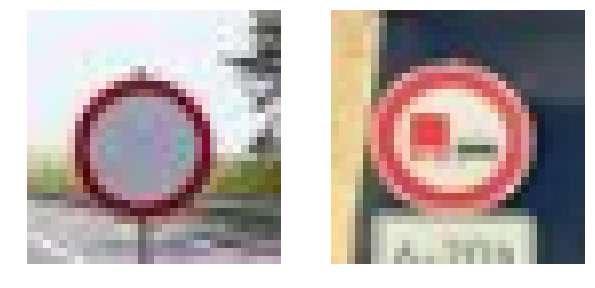

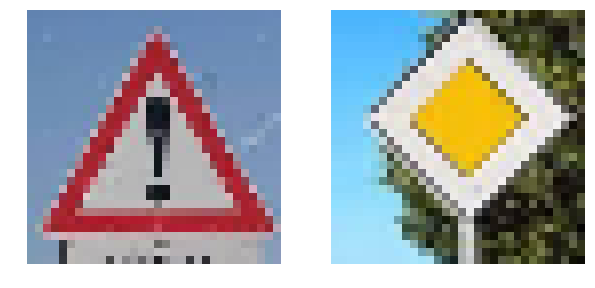

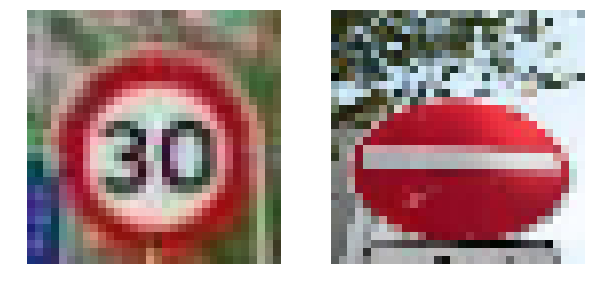

In [40]:

#testing_file = '/home/workspace/CarND-Traffic-Sign-Classifier-Project/verbotten.jpeg'
img_list=(glob.glob('/home/workspace/CarND-Traffic-Sign-Classifier-Project/*.jpeg'))

#print(img_list)
def read_rezize (img):
    img_cv2 = cv2.imread(img)
    im_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    im_rgb = cv2.resize(im_rgb, (32,32))
    #plt.imshow(im_rgb)
    return(im_rgb)
#print(img_list)

for img in img_list:
    read_rezize(img)
    
n_list=[read_rezize(img) for img in img_list]    
    
grid_display(n_list)


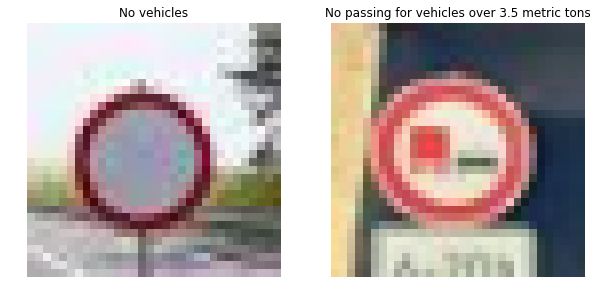

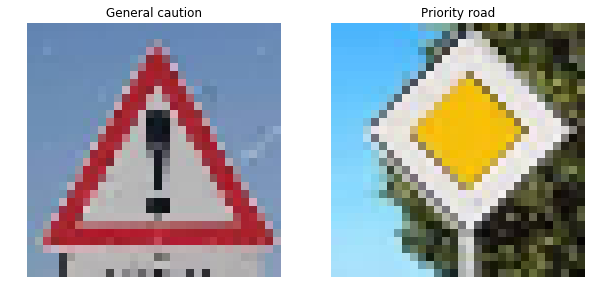

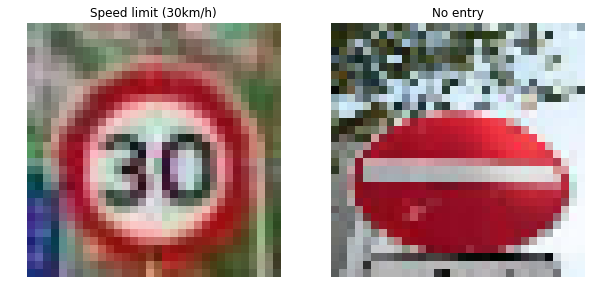

In [46]:
path='/home/workspace/CarND-Traffic-Sign-Classifier-Project/signnames.csv'
file=open(path,newline='')
reader=csv.reader(file)
next(reader)
signs_dico = {read[0]:read[1] for read in reader}
#print(signs_dico.values())

pred=predict_result(np.array(n_list))
predict_list=list(np.reshape(pred,len(pred)))
#print(predict_list)
#print(type(predict_list))
#print(signs_dico)

pred_names=[signs_dico[str(n)] for n in list(predict_list)]

#print(pred_names)

grid_display(n_list, pred_names)

In [21]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
nbpred=predict_result(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, nbpred))



             precision    recall  f1-score   support

          0       0.97      0.98      0.98        60
          1       0.97      0.99      0.98       720
          2       0.90      0.98      0.94       750
          3       0.96      0.91      0.93       450
          4       0.99      0.96      0.97       660
          5       0.92      0.85      0.88       630
          6       0.97      0.87      0.92       150
          7       0.97      0.82      0.89       450
          8       0.82      1.00      0.90       450
          9       0.99      0.97      0.98       480
         10       0.99      1.00      0.99       660
         11       0.96      0.88      0.92       420
         12       1.00      1.00      1.00       690
         13       0.99      0.99      0.99       720
         14       1.00      0.97      0.99       270
         15       0.97      1.00      0.98       210
         16       0.96      1.00      0.98       150
         17       1.00      1.00      1.00   

In [35]:
from sklearn.metrics import confusion_matrix

a=confusion_matrix(y_test, nbpred)
print(a)

[[ 59   0   0 ...,   0   0   0]
 [  0 710   6 ...,   0   0   0]
 [  0   6 738 ...,   0   0   0]
 ..., 
 [  0   1   0 ...,  82   0   0]
 [  0   0   0 ...,   0  49   0]
 [  0   0   0 ...,   3   0  71]]


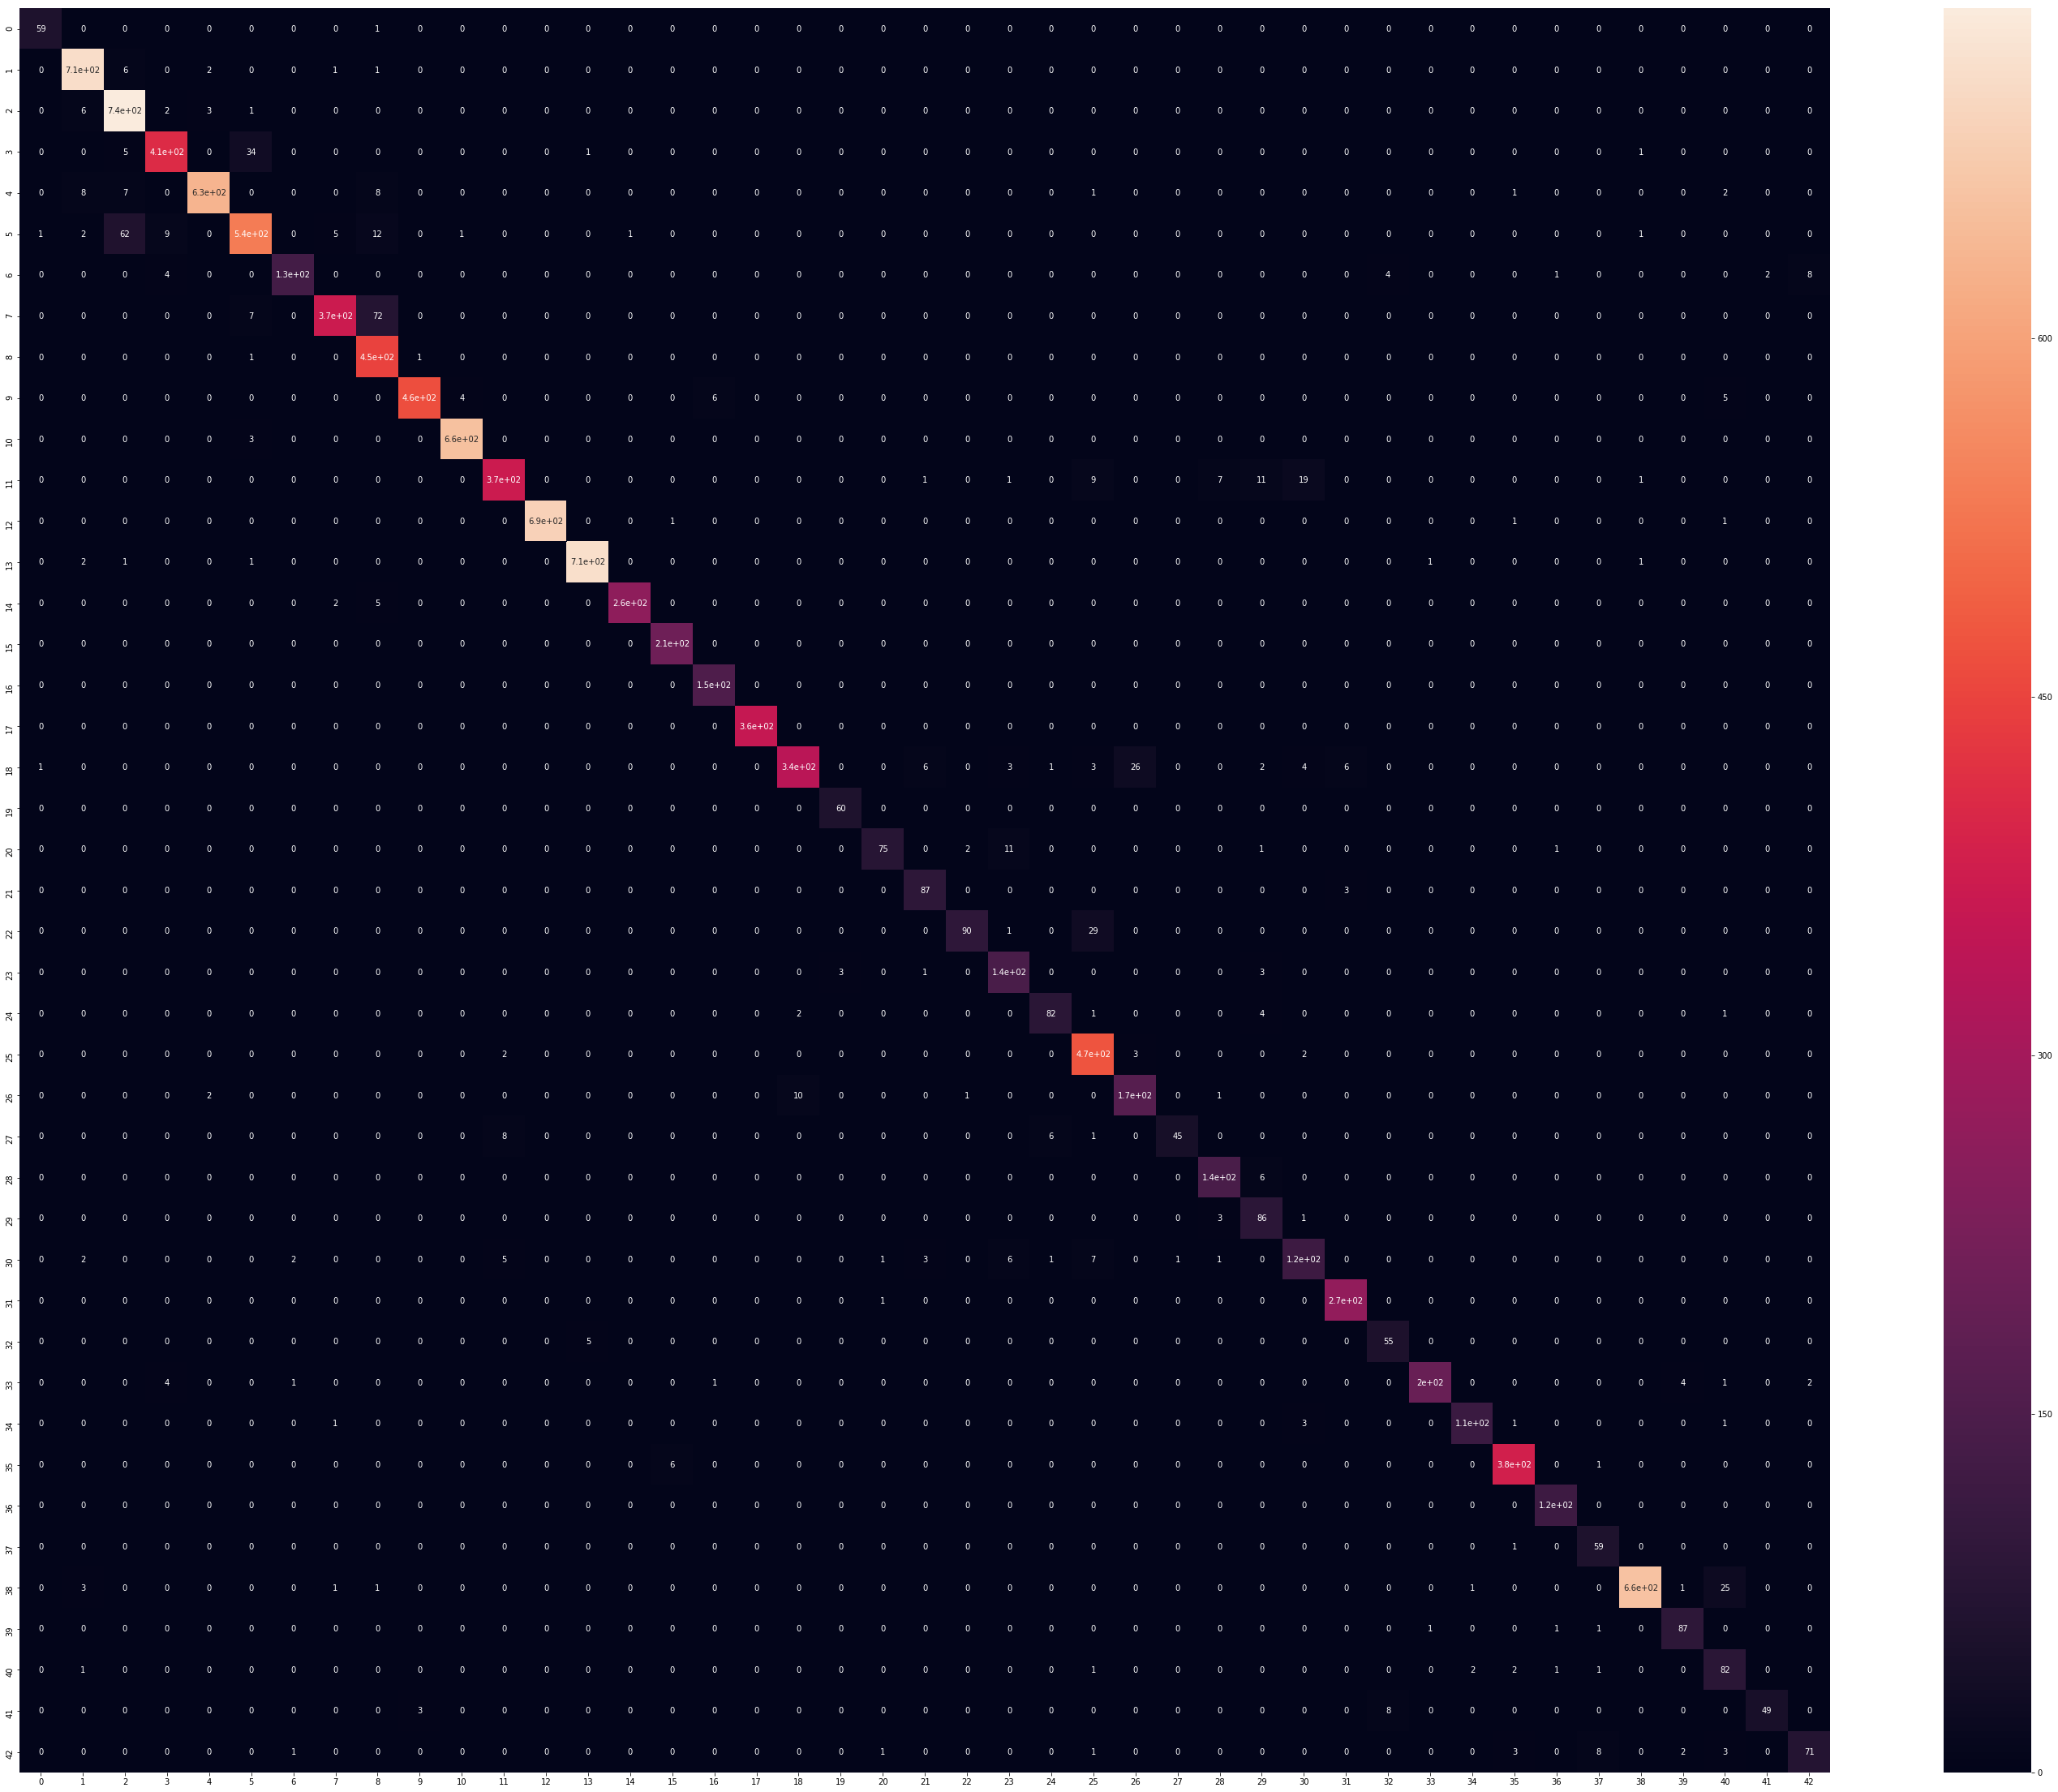

In [33]:
#signs_list= list of labels for all classes

path='/home/workspace/CarND-Traffic-Sign-Classifier-Project/signnames.csv'
file=open(path,newline='')
reader=csv.reader(file)
next(reader)
signs_list = [read[0] for read in reader]

df_cm = pd.DataFrame(a, index = signs_list,columns = signs_list)
plt.figure(figsize = (50,40))
sn.heatmap(df_cm, annot=True)
# confusion matcix doc: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix